# Denoising Probabilistic Diffusion Models

In [ ]:
import sys

# Colab-only setup
if "google.colab" in sys.modules:
    print("Running in Google Colab. Setting up repo")

    !git clone https://github.com/MatthiasCr/Diffusion-Models-Assignment.git
    %cd Diffusion-Models-Assignment

In [ ]:
!pip install torch fiftyone wandb open-clip-torch git+https://github.com/openai/CLIP.git

In [59]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import clip
import open_clip
import wandb
import urllib.request
import fiftyone as fo
import fiftyone.brain as fob
from fiftyone.utils.huggingface import push_to_hub
from torchvision.models import inception_v3, Inception_V3_Weights
import torchvision.transforms.v2 as transforms
from torchvision.utils import save_image, make_grid
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

from utils import UNet_utils, ddpm_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Part 1

In [ ]:
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)

IMG_SIZE = 32
IMG_CH = 3
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)
GUIDANCE_WEIGHT = 2.0

ddpm = ddpm_utils.DDPM(B, device)

# Initialize the U-Net model
model = UNet_utils.UNet(
    T, img_ch=3, img_size=32, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=512
).to(device)

# load clip model used to embed text prompts
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

download and use pretrained weights

In [ ]:
weights_path = "weights/model.pth"
url = "https://github.com/MatthiasCr/Diffusion-Models-Assignment/releases/download/v1/model_weights.pth"

os.makedirs("weights", exist_ok=True)

if not os.path.exists(weights_path):
    print("Downloading pretrained weights")
    urllib.request.urlretrieve(url, weights_path)

model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

In [75]:
text_prompts = [
    "A photo of a red rose",
    "A photo of a white daisy",
    "A photo of a yellow sunflower",
    "A close-up photo of a rose",
    "A sunflower in daylight",
    "An image of a red rose",
    "A picture of a white daisy",
    "A photograph of a sunflower",
    "A yellow rose",
    "A red daisy",
    "A sunflower with orange petals",
    "A photo of a tulip",
    "A purple tulip",
    "A photo of a white dandelion",
    "A purple flower",
    "A colerful flower",
]

# repeat each prompt 8 times to generate multiple images per prompt
text_prompts = [p for p in text_prompts for _ in range(8)]

In [76]:
# Register a forward hook on the `down2` layer of the U-Net model.
embeddings_storage = {}

def get_embedding_hook(name):
    def hook(model, input, output):
        embeddings_storage[name] = output.detach()
    return hook

model.down2.register_forward_hook(get_embedding_hook('down2'))

# function to generate flower images from prompts
def sample_flowers(text_list):
    text_tokens = clip.tokenize(text_list).to(device)
    c = clip_model.encode_text(text_tokens).float()
    x_gen, x_gen_store = ddpm_utils.sample_w(model, ddpm, INPUT_SIZE, T, c, device, w_tests=[GUIDANCE_WEIGHT])
    return x_gen, x_gen_store


generated_images, _ = sample_flowers(text_prompts)
extracted_embeddings = embeddings_storage['down2']

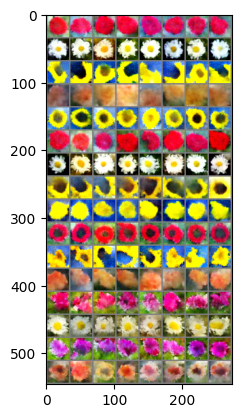

In [77]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))

grid = make_grid(generated_images.cpu())
show_tensor_image([grid])
plt.show()

In [78]:
n_generated_images = generated_images.shape[0]

# Select the embeddings corresponding to the guided pass
embeddings_guided_pass = extracted_embeddings[:n_generated_images]

# Flatten the all dimensions except batch
flattened_embeddings = embeddings_guided_pass.view(n_generated_images, -1)

In [79]:
# Save generated images as .png
images_dir = "generated_images"
os.makedirs(images_dir, exist_ok=True)

image_filepaths = []
for i, img_tensor in enumerate(generated_images):
    img_filename = os.path.join(images_dir, f"generated_image_{i}.png")
    save_image(img_tensor, img_filename)
    image_filepaths.append(img_filename)

## Part 2: Evaluation with CLIP Score and Frechet Inception Distance


In [80]:
# Load clip model used for calculating the clip score
clip_score_model, _, clip_score_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
clip_score_tokenizer = open_clip.get_tokenizer('ViT-B-32')

def calculate_clip_score(image_path, text_prompt):
    # Preprocess inputs
    image = clip_score_preprocess(Image.open(image_path)).unsqueeze(0)
    clip_score_tokenizer = open_clip.get_tokenizer('ViT-B-32')
    text = clip_score_tokenizer([text_prompt])

    with torch.no_grad():
        image_features = clip_score_model.encode_image(image)
        text_features = clip_score_model.encode_text(text)
        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        # Calculate dot product
        score = (image_features @ text_features.T).item()
    return score

In [81]:
clip_scores = []
for i in range(n_generated_images):
    clip_score = calculate_clip_score(image_filepaths[i], text_prompts[i])
    clip_scores.append(clip_score)
    print(f"CLIP score for image {i}: {clip_score}")

CLIP score for image 0: 0.296175092458725
CLIP score for image 1: 0.24442243576049805
CLIP score for image 2: 0.28146499395370483
CLIP score for image 3: 0.26958346366882324
CLIP score for image 4: 0.26721814274787903
CLIP score for image 5: 0.24295574426651
CLIP score for image 6: 0.2722580134868622
CLIP score for image 7: 0.24473215639591217
CLIP score for image 8: 0.2891899347305298
CLIP score for image 9: 0.31352031230926514
CLIP score for image 10: 0.24937960505485535
CLIP score for image 11: 0.2750787138938904
CLIP score for image 12: 0.2961256206035614
CLIP score for image 13: 0.2711813449859619
CLIP score for image 14: 0.26624128222465515
CLIP score for image 15: 0.25945812463760376
CLIP score for image 16: 0.21836838126182556
CLIP score for image 17: 0.21602942049503326
CLIP score for image 18: 0.26177898049354553
CLIP score for image 19: 0.22663015127182007
CLIP score for image 20: 0.19811773300170898
CLIP score for image 21: 0.24730052053928375
CLIP score for image 22: 0.268

In [82]:
def calculate_fid(real_embeddings, gen_embeddings):
    # real_embeddings and gen_embeddings should be Numpy arrays of shape (N, 2048)
    # extracted from an InceptionV3 model
    # Calculate mean and covariance
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = gen_embeddings.mean(axis=0), np.cov(gen_embeddings, rowvar=False)
    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2)
    # Calculate sqrt of product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))
    # Handle numerical errors
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # Final FID calculation
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [83]:
inception = inception_v3(weights=Inception_V3_Weights.DEFAULT).to(device)
inception.fc = nn.Identity()  # Replace classifier with passthrough
inception.eval()

preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

with torch.no_grad():
    inception_embeddings_generated = inception(preprocess(generated_images))

In [ ]:
!wget http://download.tensorflow.org/example_images/flower_photos.tgz
!tar -xzf flower_photos.tgz

In [43]:
dataset = ImageFolder("flower_photos", transform=preprocess)
tf_flowers_loader = DataLoader(dataset, batch_size=32, shuffle=False)

inception_embeddings_real = []

with torch.no_grad():
    for images, _ in tf_flowers_loader:
        images = images.to(device)
        emb = inception(preprocess(images))
        inception_embeddings_real.append(emb)

inception_embeddings_real = torch.cat(inception_embeddings_real, dim=0)

In [84]:
fid_score = calculate_fid(inception_embeddings_real.cpu().numpy(), inception_embeddings_generated.cpu().numpy())
print(f"FID score for dataset: {fid_score}")

FID score for dataset: 307.58273165443325


## Part 3: Embedding Analysis with FiftyOne Brain

In [86]:
dataset = fo.Dataset(name="generated_flowers_with_embeddings2")

samples = []
for i in range(n_generated_images):
    sample = fo.Sample(filepath=image_filepaths[i])
    sample["text_prompt"] = fo.Classification(label=text_prompts[i])
    sample["unet_embedding"] = flattened_embeddings[i].tolist()
    sample["clip_score"] = clip_scores[i]
    samples.append(sample)

dataset.add_samples(samples)
dataset.info["fid_score"] = fid_score

 100% |█████████████████| 128/128 [10.9s elapsed, 0s remaining, 8.1 samples/s]       


INFO:eta.core.utils: 100% |█████████████████| 128/128 [10.9s elapsed, 0s remaining, 8.1 samples/s]       


In [ ]:
# Compute uniqueness and representativeness.
fob.compute_uniqueness(dataset)
fob.compute_representativeness(dataset, embeddings="unet_embedding")

In [ ]:
# compute embedding visualization
pca_viz = fob.compute_visualization(
    dataset,
    method="pca",
    embeddings="unet_embedding",
    num_dims=2,
    brain_key="pca_unet_embeddings"
)

In [ ]:
session = fo.launch_app(dataset, auto=False)


In [ ]:
session.refresh()
print(session.url)

In [ ]:
!hf auth login

# push fiftyone dataset to huggingface
push_to_hub(dataset, "generated_flowers", exist_ok=True)

## Part 4: Logging with Weights & Biases

In [50]:
WANDB_TEAM_NAME = "matthiascr-hpi-team"
WANDB_PROJECT_NAME = "diffusion_model_assessment"

In [ ]:
wandb.login()

In [94]:
run = wandb.init(
    entity = WANDB_TEAM_NAME,
    project = WANDB_PROJECT_NAME,
    config = {
        "T": T,
        "W": GUIDANCE_WEIGHT,
        "n_samples": n_generated_images,
    })

table = wandb.Table(
    columns=["image", "prompt", "CLIP_score", "uniquness", "representativeness"]
)

for i in range(n_generated_images):
  run.log({"clip_score": clip_scores[i]})

  table.add_data(
      wandb.Image(image_filepaths[i]),
      text_prompts[i],
      clip_scores[i],
      samples[i].uniqueness,
      samples[i].representativeness
  )

run.log({
    "dataset_images": table,
    "fid_score": fid_score,
    "average_clip_score": np.mean(clip_scores)
    })

run.finish()

average_clip_score,▁
clip_score,▆▆▆▇▆▅▄▆▆▄▆▇▆▆▇█▆▅▆▆▄▅▅▄▄▁▂▄▄▅▄▃▆▅▅▄▅▆▅▇
fid_score,▁
average_clip_score,0.23871
clip_score,0.29536
fid_score,307.58273
